This notebook is based largely on https://github.com/tolga-b/debiaswe/blob/master/tutorial_example1.ipynb and also on Andrew Ngs coursera deep learning specialization - https://www.coursera.org/learn/nlp-sequence-models

You can download both w2v_gnews_small.txt and professions.json from Tolgas github repository

## Load a Pre-trained Word2Vec Model

(using Tolgas smaller version of w2v_gnews)

In [1]:
import numpy as np
import gensim 

# load the data
#model = gensim.models.KeyedVectors.load_word2vec_format('../../data/GoogleNews-vectors-negative300.bin', binary=True)
words = {}
with open('w2v_gnews_small.txt','r', encoding='utf8') as f:
    for line in f:
        s = line.split()
        word = s[0].lower()
        vector = np.array([float(x) for x in s[1:]])
        words[word] = vector

In [2]:
print(len(words), "words")
print(len(words['hello']), "dimensions")

26423 words
300 dimensions


## Similarity

In [3]:
# similarity function from AndrewNg
def cosine_similarity(u,v):
    dot = np.dot(u,v)
    norm_u = np.sqrt(np.sum(u*u))
    norm_v = np.sqrt(np.sum(v*v))
    cosine_similarity = dot / (norm_u*norm_v)
    
    return cosine_similarity

The larger the cosine similarity, the more similar the words are 

In [4]:
cosine_similarity(words['father'], words['mother'])

0.7901483260108079

In [5]:
cosine_similarity(words['accountant'], words['volleyball'])

0.056563999449795864

## Analogy

Complete the analogy "Man is to King as Woman is to ?"

In [7]:
# code from AndrewNg
def complete_analogy(a, b, x, model):
    e_a = model[a.lower()]
    e_b = model[b.lower()]
    e_x = model[x.lower()]
   
    words = model.keys()
    max_cosine_sim = -100
    best_word = None
    
    for w in words:
        if w in [a, b, x]:
            continue
        
        cosine_sim = cosine_similarity(e_b - e_a, model[w]-e_x)
        
        if cosine_sim > max_cosine_sim:
            max_cosine_sim = cosine_sim
            best_word = w
            
    return best_word

Some gender appropriate analogies

In [8]:
analogies = [('man', 'woman', 'boy'), 
             ('he', 'brother', 'she'),
             ('small', 'smaller', 'large'), 
             ('man','king','woman'),
             ('he','prostate_cancer', 'she')]
for analogy in analogies:
    print ('{} -> {} :: {} -> {}'.format( *analogy, complete_analogy(*analogy, words)))

man -> woman :: boy -> girl
he -> brother :: she -> sister
small -> smaller :: large -> larger
man -> king :: woman -> queen
he -> prostate_cancer :: she -> ovarian_cancer


And some more stereotypical

In [9]:
analogies = [('he', 'doctor', 'she'),               
             ('he','blue','she'),
             ('she', 'buns', 'he')]
for analogy in analogies:
    print ('{} -> {} :: {} -> {}'.format( *analogy, complete_analogy(*analogy, words)))

he -> doctor :: she -> nurse
he -> blue :: she -> pink
she -> buns :: he -> sausages


# Debiasing word embeddings

## 1. Determine gender direction

For simplicity we choose the She-He direction, in reality we should take a number of different gender definition pairs and find the Principal Component

In [10]:
g = words['she']-words['he']

## Bias in words

How much bias is there?  The more positive the more female the word is considered.

In [11]:
def print_barchart(word_dict):
    import pandas as pd
    df = pd.DataFrame(word_dict)
    df.sort_values(by='she_bias', inplace=True)
    df['positive'] = df['she_bias']>0
    df.plot(kind='barh',x='key', color=[df.positive.map({True: 'r', False: 'b'})])

In [13]:
%matplotlib inline

Testing with names: Here the bias is expected and wanted

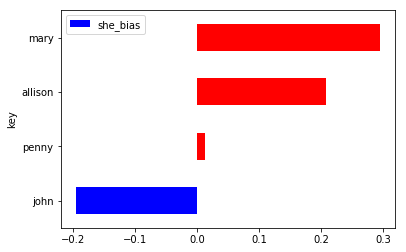

In [14]:
name_list = ['john', 'mary', 'allison', 'penny']

names = [{'key': name, 'she_bias':cosine_similarity(words[name],g)} for name in name_list]
print_barchart(names)

And some words that should really be gender neutral 

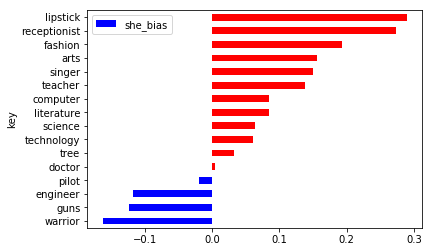

In [15]:
word_list = ['lipstick', 'guns', 'science', 'arts', 'literature', 'warrior','doctor', 'tree', 'receptionist', 
             'technology',  'fashion', 'teacher', 'engineer', 'pilot', 'computer', 'singer']
word_dict = [{'key': w, 'she_bias':cosine_similarity(words[w],g)} for w in word_list]
print_barchart(word_dict)

And then some professions from Tolgas list of professions

In [16]:
import os
import json

professions_file = 'embedding-info/professions.json'
with open(professions_file, 'r') as f:
    professions = json.load(f)
profession_words = [p[0] for p in professions]

In [17]:
profession_dict = [{'key': w, 'she_bias':cosine_similarity(words[w],g)} for w in profession_words]

In [19]:
import pandas as pd
df = pd.DataFrame(profession_dict)
df.sort_values(by='she_bias', inplace=True)

The most male professisons

In [20]:
df.head(10)

,key,she_bias
174,maestro,-0.237984
283,statesman,-0.216655
273,skipper,-0.207587
241,protege,-0.202672
46,businessman,-0.202068
281,sportsman,-0.194924
215,philosopher,-0.188364
180,marksman,-0.180737
54,captain,-0.172899
16,architect,-0.167856


And the most female ones

In [21]:
df.tail(10)

,key,she_bias
274,socialite,0.257188
170,librarian,0.266471
252,receptionist,0.273176
313,waitress,0.275403
200,nurse,0.280860
253,registered_nurse,0.304262
146,homemaker,0.304380
149,housewife,0.340366
3,actress,0.352351
47,businesswoman,0.359654


## Neutralize

$$e^{bias\_component} = \frac{e \cdot g}{||g||_2^2} * g\tag{2}$$$$e^{debiased} = e - e^{bias\_component}\tag{3}$$

In [22]:
# Code from AndrewNg
def neutralize(word, g, model):
    """
    Remove the bias by projecting the word on the space 
    orthogonal to the bias vector
    """
    emb = model[word]
    emb_bias = np.divide(np.dot(emb, g), np.linalg.norm(g)**2)*g
    emb_debiased = emb - emb_bias
    return emb_debiased

In [23]:
word = "receptionist"
print(word, "before: ", cosine_similarity(words[word],g))
debiased_embedding = neutralize(word, g, words)
print(word, "after: ", cosine_similarity(debiased_embedding,g))

receptionist before:  0.2731762944615335
receptionist after:  -6.315754838469021e-17


## Equalize

$$ \mu = \frac{e_{w1} + e_{w2}}{2}\tag{1}$$

$$ \mu_{B} = \frac {\mu \cdot \text{bias_axis}}{||\text{bias_axis}||_2^2} *\text{bias_axis}
\tag{2}$$

$$\mu_{\perp} = \mu - \mu_{B} \tag{3}$$

$$ e_{w1B} = \frac {e_{w1} \cdot \text{bias_axis}}{||\text{bias_axis}||_2^2} *\text{bias_axis}
\tag{4}$$

$$e_{w1B}^{corrected} = \sqrt{ |{1 - ||\mu_{\perp} ||^2_2} |} * \frac{e_{\text{w1B}} - \mu_B} {||(e_{w1B} - \mu_B)||_2} \tag{5}$$

$$e_1 = e_{w1B}^{corrected} + \mu_{\perp} \tag{6}$$


In [24]:
# Code from AndrewNg
def equalize(pair, g, model):
    w1, w2 = pair
    e_w1, e_w2 = model[w1], model[w2]
    
    # (1) find the mid point (mean) 
    mu = (e_w1 + e_w2)/2
    
    # (2 + 3) compute the projections of mu over the bias
    mu_B = np.divide(np.dot(mu, g), np.linalg.norm(g)**2)*g
    mu_orth = mu - mu_B
    
    # (4) compute e_w1B and e_w2B
    e_w1B = np.divide(np.dot(e_w1, g),np.linalg.norm(g)**2)*g
    e_w2B = np.divide(np.dot(e_w2, g),np.linalg.norm(g)**2)*g
    
    # (5) adjust the bias part 
    corrected_e_w1B = np.sqrt(np.abs(1-np.sum(mu_orth**2)))*np.divide(e_w1B-mu_B, np.abs(e_w1-mu_orth-mu_B))
    corrected_e_w2B = np.sqrt(np.abs(1-np.sum(mu_orth**2)))*np.divide(e_w2B-mu_B, np.abs(e_w2-mu_orth-mu_B))

    # (6) debias by equalizing e1 and e2 to the sum of their corrected projections
    e1 = corrected_e_w1B + mu_orth
    e2 = corrected_e_w2B + mu_orth
    
    return e1,e2

In [25]:
print('before')
print('man', cosine_similarity(words['man'],g))
print('woman', cosine_similarity(words['woman'],g))
e1, e2 = equalize(("man","woman"), g, words)
print('after')
print('man', cosine_similarity(e1,g))
print('woman', cosine_similarity(e2,g))

before
man -0.18997453023523314
woman 0.32475201469943954
after
man -0.3275753311187496
woman 0.3247739028841863
